<a href="https://colab.research.google.com/github/Adivah12/Machine-Learning/blob/main/CNN_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARY

In [20]:
from google.colab import files    # Untuk upload files
import zipfile                    # Untuk unzip file
import os                         # Untuk interaksi dengan os
import matplotlib.pyplot as plt   # Untuk visualisasi data
import matplotlib.image as mpimg  # Membaca dan memanipulasi gambar
from google.colab import drive    # Untuk mengakses google drive
import tensorflow as tf           # Library utama untuk Machine learning
import numpy as np                # Library untuk komputasi numerik

In [2]:
# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
batch_size = 32
img_height = 224
img_width = 224

# PERSIAPAN DATASET


Mengambil dataset dari kaggle

In [3]:
!pip install -q Kaggle

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.kaggle                #membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle/         #memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json   #merubah permission file kaggle.json

In [6]:
!kaggle datasets download -d adityavahreza/cat-skin-disease

Dataset URL: https://www.kaggle.com/datasets/adityavahreza/cat-skin-disease
License(s): unknown
 26% 5.00M/19.6M [00:00<00:00, 45.1MB/s]
100% 19.6M/19.6M [00:00<00:00, 106MB/s] 


Load Dataset


In [7]:
# Extract zipfile
! unzip "/content/cat-skin-disease.zip" -d.

Archive:  /content/cat-skin-disease.zip
  inflating: ./CAT SKIN DISEASE/Health/04ab5725b230e3d3e76031f9cf1c95f9_jpg.rf.405ef84073960c0085b2018d77d0375e.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0bc984c93228017f4727e0c852126f7d_jpg.rf.bf7d7a91fa42774fa38b03cbcf58c5c1.jpg  
  inflating: ./CAT SKIN DISEASE/Health/0f210d552b92c7204442138de5151b55_jpg.rf.aae8a1537e4f29b4c09fce3c0a4091e7.jpg  
  inflating: ./CAT SKIN DISEASE/Health/15a8e5d7bc0011c973b3fa37e490bd7a_jpg.rf.c45bdc80a9bcd5b6655b586ed3f3fc48.jpg  
  inflating: ./CAT SKIN DISEASE/Health/1e161cf3433aee7231b8b56333127e5c_jpg.rf.a39934baa8d1de7b2e4d01a9c404bcb1.jpg  
  inflating: ./CAT SKIN DISEASE/Health/20d4646247bd7033d6d76f64566f0052_jpg.rf.219ac65aabce12bf7c00ff09bb2bc9d3.jpg  
  inflating: ./CAT SKIN DISEASE/Health/26da1f8b744ccff35a3cba4026407b9d_jpg.rf.2abec213f35d42b8b46604a65cc38956.jpg  
  inflating: ./CAT SKIN DISEASE/Health/2b9be78add42a048bc7cca3afee5ca6c_jpg.rf.dc9218d7696d506344ffadfec4bf4e2a.jpg  
  inflating: ./C

Menentukan class

In [8]:
cat_disease = "/content/CAT SKIN DISEASE"
cat_disease_classes = os.listdir(cat_disease)

In [9]:
print("Cat Skin Disease Class :")
for class_name in cat_disease_classes:
  if os.path.isdir(os.path.join(cat_disease, class_name)):
    print(class_name)

Cat Skin Disease Class :
Health
Scabies
Lepra
Ringworm


Preview Gambar


Health
Total Image :  99
Resolusi Gambar :  (640, 640, 3)


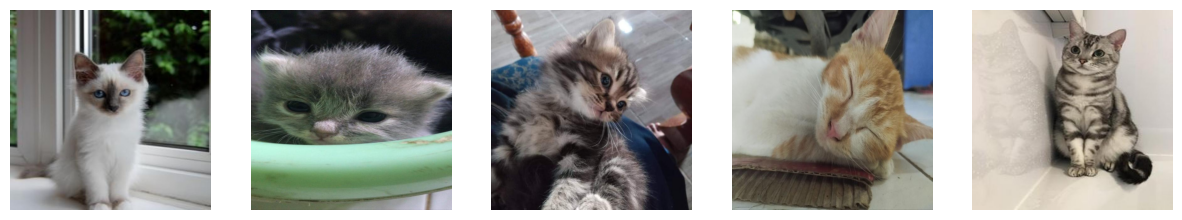


Scabies
Total Image :  109
Resolusi Gambar :  (260, 272, 4)


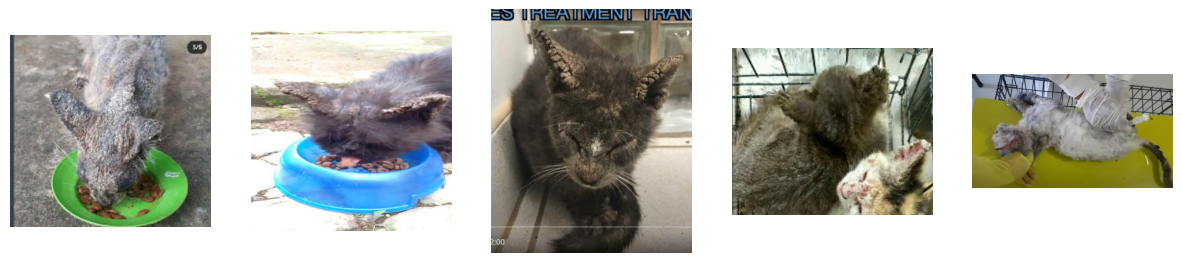


Lepra
Total Image :  100
Resolusi Gambar :  (224, 224, 3)


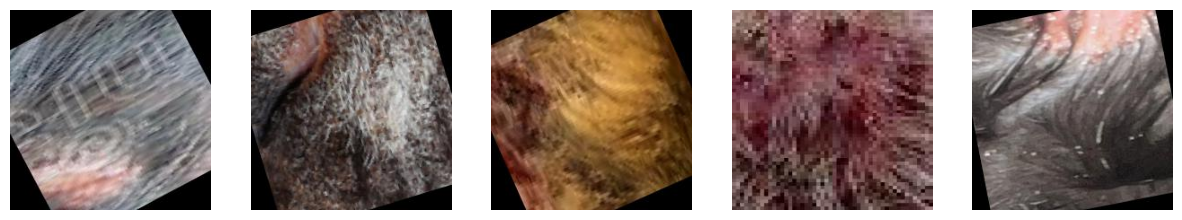


Ringworm
Total Image :  103
Resolusi Gambar :  (640, 640, 3)


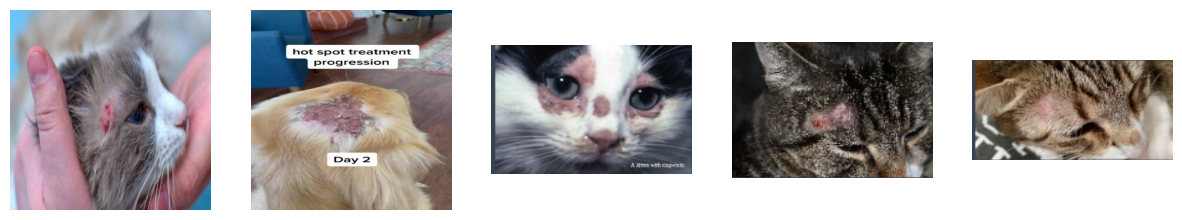

In [10]:
for item in cat_disease_classes:
    print("")
    print(item)
    class_dir = os.path.join(cat_disease, item)
    class_images = [img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Menghitung total image di setiap kelas
    num_images = len(class_images)
    print("Total Image : ", num_images)

    # Menghitung resolusi pada gambar pertama
    img_path = os.path.join(class_dir, class_images[0])
    img = mpimg.imread(img_path)
    image_shape = img.shape
    print("Resolusi Gambar : ", image_shape)

    # Menampilkan beberapa gambar
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(class_images))):  # Tampilkan maksimum 5 gambar atau sesuai jumlah yang tersedia
        sp = plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(class_dir, class_images[i]))
        plt.axis('off')
        plt.imshow(img)
    plt.show()


# PREPOCESING DATA


Split data

In [44]:
def train_val_Dataset():
  training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
      cat_disease,
      image_size=(img_height, img_width),
      color_mode='rgb',
      batch_size= batch_size,
      label_mode='categorical',
      validation_split=0.2,
      subset='both',
      seed=42
  )

  return training_dataset, validation_dataset

In [45]:
# Membuat dataset
training_dataset, validation_dataset = train_val_Dataset()

Found 411 files belonging to 4 classes.
Using 329 files for training.
Using 82 files for validation.


In [46]:
# Melihat batch pertama dari image dan labels
for image_batch, labels_batch in training_dataset.take(1):
  example_batch = image_batch
  labels_batch = labels_batch

  print(f"maximum pixel value of images : {np.max(example_batch)}.\n")
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {labels_batch.shape}")

maximum pixel value of images : 255.0.

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)


Augmentation

In [34]:
def create_augmentation_model():
  augmentation_model = tf.keras.Sequential([
      tf.keras.Input(shape=(224, 224, 3)),
      tf.keras.layers.RandomFlip("horizontal"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.2),
      tf.keras.layers.RandomContrast(0.2),
  ])

  return augmentation_model


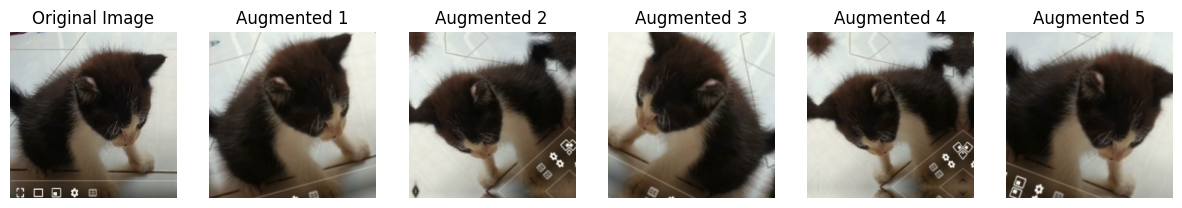

In [40]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch[0])

images = [sample_image]

# Apply random augmentation 5 times
for _ in range(5):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 6, figsize=(15, 5))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3','Augmented 4','Augmented 5']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

# MODELING

In [49]:
def create_model():

  augmentation_layers = create_augmentation_model()

  model = tf.keras.models.Sequential([
      augmentation_layers,

      # Rescahling input shape
      tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

      # Convolutional and pooling layers
      tf.keras.layers.Conv2D(32,(3,3), activation='relu'), # Changed conv2D to Conv2D
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation='relu'), # Changed conv2D to Conv2D
      tf.keras.layers.MaxPooling2D(2,2),

      # Flatten and dense layer
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),

      # Output layers
      tf.keras.layers.Dense(4, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )


  return model

In [50]:
create_model().summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,652 (45.64 MB)

 Trainable params: 11,963,652 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

Buat fungsi callback

In [51]:
class early_stopping_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy')>=0.85 and logs.get('val_accuracy')>=0.9:
      print("\nReached 85% train accuracy and 90% accuracy so cancelling training!")
      self.model.stop_training = True

Mulai train model

In [52]:
history = create_model().fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping_callback()]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2488 - loss: 2.8672 - val_accuracy: 0.3171 - val_loss: 1.3713
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3083 - loss: 1.3664 - val_accuracy: 0.2561 - val_loss: 1.3543
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.3442 - loss: 1.3310 - val_accuracy: 0.3902 - val_loss: 1.3297
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3670 - loss: 1.3029 - val_accuracy: 0.4024 - val_loss: 1.2803
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3779 - loss: 1.2548 - val_accuracy: 0.4756 - val_loss: 1.1478
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.4289 - loss: 1.2045 - val_accuracy: 0.4878 - val_loss: 1.1423
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.4693 - loss: 1.1649 - val_accuracy: 0.5366 - val_loss: 1.1081
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5160 - loss: 1.1199 - val_accuracy: 0.5366 - val_loss:

# Hasil Model

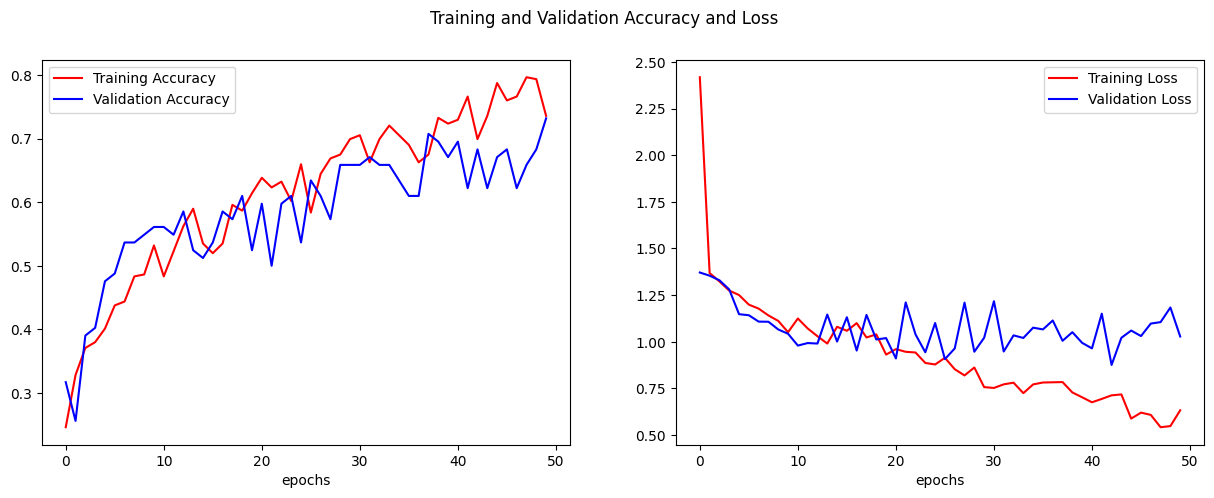

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Training and Validation Accuracy and Loss')

# Define data and labels for each subplot
data_labels = [
    (acc, val_acc, 'Accuracy'),
    (loss, val_loss, 'Loss')
]

# Iterate through subplots and data
for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    axs[i].plot(epochs_range, data[0], 'r', label="Training " + label)
    axs[i].plot(epochs_range, data[1], 'b', label="Validation " + label)
    axs[i].legend()
    axs[i].set_xlabel('epochs')

plt.show()